In [633]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import wbgapi as wb
import matplotlib.pyplot as plt
import geopandas as gpd
import openpyxl
import math
import seaborn as sns

## Atabey's notes

* Q1: You don't have the function I asked for. But the rest is done properly. (23pts)
* Q2: Data cleaning is done ok but no population map and the crime map is not done correctly. A choropleth map would encode the population levels with colors. (17pts)
* Q3: Everything looks good. There is a slight mistake in the scatter plots of pairs of columns. Instead of a particular country, the plot should have included the data for every country for those columns and time frame. (30pts)

## Q1

I couldn't use api to pull the data, so I only implemented the examples over a single data set. I named the data I will use as data.

In [634]:
data = pd.read_csv("https://data.ibb.gov.tr/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/5fb30ee1-e079-4865-a8cd-16efe2be8352/download/traffic_density_202002.csv")

After pulling the data, I first groupby it with the "GEOHASH" line and then performed the aggragate operation with the desired parameters.

In [635]:
aggragated = data.groupby(['GEOHASH']).agg({
    "LONGITUDE": "first",
    "LATITUDE": "first",
    "AVERAGE_SPEED": "mean",
    "NUMBER_OF_VEHICLES": "mean"
    })

I stored some desired data from the aggregated data in variables matching their names

In [636]:
highest_speed = aggragated.nlargest(25, "AVERAGE_SPEED")["AVERAGE_SPEED"]
lowest_speed = aggragated.nsmallest(25, "AVERAGE_SPEED")["AVERAGE_SPEED"]
highest_number_of_vehicles = aggragated.nlargest(25, "NUMBER_OF_VEHICLES")["NUMBER_OF_VEHICLES"]


I created a map of Istanbul with the Folium library. Here is the site where I got the coordinates: https://www.latlong.net/place/istanbul-turkey-2242.html

In [637]:
istanbul = folium.Map(location=(41.015137, 28.979530), zoom_start = 11)

After creating the map, I stored the coordinates and NUMBER_OF_VEHICLES in the data I pulled above in a variable called heat_data.

In [638]:
heat_data = [[row['LONGITUDE'], row['LATITUDE'], row['NUMBER_OF_VEHICLES']] for index, row in data.iterrows()]

Finally, I mapped these values to the map of Istanbul and saved them in the harita.html file to be displayed

In [639]:
HeatMap(heat_data).add_to(istanbul)
istanbul.save("harita.html")

## Q2

I pull the desired maps, population and crime information from the requested websites.

In [640]:
level0_map = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_TUR_1.json")
level1_map = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_TUR_2.json")
level0_pop = pd.read_excel("C:/Users/apthz/Downloads/HW2-Population-level0.xlsx")
level1_pop = pd.read_excel("C:/Users/apthz/Downloads/HW2-Population-level1.xlsx")
crime = pd.read_excel("C:/Users/apthz/Downloads/HW2-Crime.xlsx")

To avoid confusion when using dataframes with Turkish characters or capital letters, I wrote a function that performs some cleaning operations

In [641]:
def be_appropriate(data, column):
    for i in data.index:
            if type(data.at[i, column]) != float:      
                data.at[i, column] = data.at[i, column].replace("Ş","s")
                data.at[i, column] = data.at[i, column].replace("İ","i")
                data.at[i, column] = data.at[i, column].replace("ı","i")
                data.at[i, column] = data.at[i, column].replace("I","i")
                data.at[i, column] = data.at[i, column].replace("Ğ","g")
                data.at[i, column] = data.at[i, column].replace("ğ","g")
                data.at[i, column] = data.at[i, column].replace("Ç","c")
                data.at[i, column] = data.at[i, column].replace("Ü","u")
                data.at[i, column] = data.at[i, column].replace("ü","u")
                data.at[i, column] = data.at[i, column].replace("ş","s")
                data.at[i, column] = data.at[i, column].replace("ç","c")
                data.at[i, column] = data.at[i, column].replace("Ö","o")
                data.at[i, column] = data.at[i, column].replace("ö","o")
                data.at[i, column] = data.at[i, column].lower()

I do some operations to correct the improper structure of the TUIK data.
First I remove unnecessary lines by shifting up with the shift function.
Then I clean the names using the function above.
I manually correct the names that remain incompatible despite the function.
In order to get rid of the complex indexing in the district data, I bring the names of the provinces before the districts.

In [642]:
level0_pop = level0_pop.shift(-10)[:81]
be_appropriate(level0_pop,"TÜRKİYE İSTATİSTİK KURUMU")
level0_pop.index = level0_pop["TÜRKİYE İSTATİSTİK KURUMU"]
level0_pop = level0_pop[["Unnamed: 1"]]
level0_pop.rename(columns = {"Unnamed: 1": "Nüfus"}, inplace=True)
level0_pop = level0_pop.rename(index={"mersin (icel)": 'mersin'})
for i in range(8,len(level1_pop)):
    if type(level1_pop.xs(i)["Unnamed: 3"]) != str and not math.isnan(level1_pop.xs(i)["Unnamed: 3"]):
        level1_pop.xs(i)["Unnamed: 2"] = level1_pop.xs(i)["Unnamed: 3"]

level1_pop.drop(["Unnamed: 3", "TÜRKİYE İSTATİSTİK KURUMU"], axis = 1, inplace = True)
level1_pop = level1_pop.shift(-8)[:946]

prev = ""
for i in range(len(level1_pop)):
    if type(level1_pop.xs(i)["Unnamed: 1"]) != str and math.isnan(level1_pop.xs(i)["Unnamed: 1"]):
        level1_pop.xs(i)["Unnamed: 1"] = prev
        
    prev = level1_pop.xs(i)["Unnamed: 1"]
        
    
be_appropriate(level1_map, "NAME_1")
be_appropriate(level1_map, "NAME_2")
be_appropriate(level1_pop, "Unnamed: 1")
be_appropriate(level1_pop, "Unnamed: 2")

I delete unnecessary columns in crime data. I correct unnecessary details in city naming using the split function. I make the data more usable by transposing it because indexing is not done well. I manually correct city naming that can escape even the clean function.

In [643]:
crime.drop(["Unnamed: 0", "Unnamed: 2"], axis = 1, inplace = True)
crime.columns = crime.xs(0)
crime.columns = crime.columns.str.split("-").str[0].str.lower()
crime = crime.shift(-3)[:-3]
col = list(crime.columns)
col[0] = "Suc Turu"
crime.columns = col
crime.index = crime["Suc Turu"]
crime.drop(["Suc Turu"], axis = 1, inplace = True)
crime = crime.T
crime = crime.rename(index={"afyonkarahisar": 'afyon'})
crime = crime.rename(index={"i̇stanbul": 'istanbul'})
crime = crime.rename(index={"i̇zmir": 'izmir'})
crime["Temp"] = crime.index
be_appropriate(crime, "Temp")
crime.index = crime["Temp"]
crime.drop(["Temp"], axis = 1, inplace = True)

For convenience when using two different data sets, I create a dictionary that stores the names of the province and district as a tuple key and the population value of this district as a value 

In [644]:
index = [(level1_pop.xs(i)["Unnamed: 1"],level1_pop.xs(i)["Unnamed: 2"]) for i in range(len(level1_pop))]
populations = {index[i]: level1_pop.xs(i)["Unnamed: 4"] for i in range(len(index))}

Since there were some minor errors in the city names in the different data, instead of manually correcting these errors, I created a dictionary that alphabetizes the cities and matches them with each other.

In [645]:
geo_cities = set(level1_map["NAME_1"])
tuik_cities = set(level1_pop["Unnamed: 1"])


tuik_cities = sorted(list(tuik_cities))
geo_cities = sorted(list(geo_cities))

merge_cities = {geo_cities[i] :tuik_cities[i] for i in range(81) }

I combined the map and population data using the two dictionaries I created above

In [646]:
level1_map["Population"] = math.nan
for i in range(1,len(level1_map)):
    level1_map.at[i,"Population"] = populations.get((merge_cities[(level1_map.xs(i)["NAME_1"])],level1_map.xs(i)["NAME_2"]), math.nan)    

after matching the population of the districts to the map, I plotted the map to show the populations

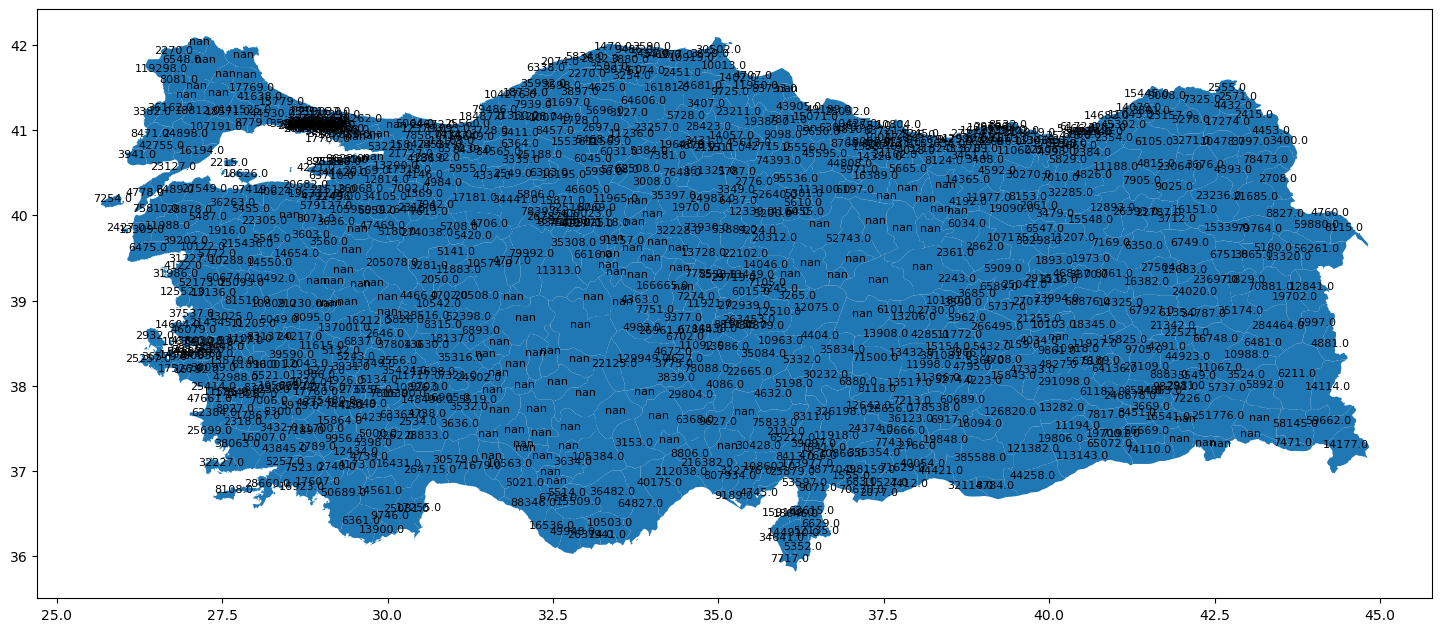

In [302]:
fig, ax = plt.subplots(figsize=(18, 8))
level1_map.plot(ax = ax)
for i in range(len(level1_map)):
    population = level1_map.xs(i)["Population"]


    country_geo = level1_map.xs(i)['geometry']
    x, y = country_geo.centroid.x, country_geo.centroid.y
    
    ax.text(x, y, f"{population}",
            fontsize=8, ha='center')



I created a population column for crime data and mapped this population to the cities in crime data

In [647]:
crime["Nüfus"] = math.nan
for i in crime.index:
    crime.at[i, "Nüfus"] = level0_pop.at[i,"Nüfus"]


## Q3

I created and stored the countries whose data I want to use, the code for the wb of the data I want to pull and the header I will use for this data later.

In [652]:
countries = ['ALB', 'BIH', 'BGR', 'HRV', 'XKX', 'MNE', 'MKD', 'ROU', 'SRB', 'SVN','TUR', 'GRC', 'CYP', 'MLT', 'ITA', 'POL', 'BLR', 'UKR']

queries = {
    "SH.DYN.MORT" : "Child Mortality",     
    "SE.ADT.LITR.FE.ZS":      "Female Literacy",
    "SL.TLF.CACT.FE.NE.ZS": "Female Workforce Participation",
    "SI.POV.LMIC": "Poverty",   
    "NY.GDP.PCAP.CD" : "GDP",
    "IQ.CPA.GNDR.XQ": "Gender Equality"
}

I pull the data I want to use and enter the data code and countries as parameters

In [651]:
wb_data = wb.data.DataFrame(list(queries.keys()), countries)

APIResponseError: APIError: JSON decoding error (https://api.worldbank.org/v2/en/sources/2/series/SH.DYN.MORT;SE.ADT.LITR.FE.ZS;SL.TLF.CACT.FE.NE.ZS;SI.POV.LMIC;NY.GDP.PCAP.CD;IQ.CPA.GNDR.XQ/country/ALB;BIH;BGR;HRV;XKX;MNE;MKD;ROU;SRB;SVN;TUR;GRC;CYP;MLT;ITA;POL;BLR;UKR/time/all?per_page=1000&page=1&format=json)

In order to make the data more usable, I first group it with the stack function, then unstack it with the unstack function, and finally name the columns with the desired headers.

In [208]:
years = list(range(1960, 2023))
wb_data.columns = years
wb_data = wb_data.stack()
wb_data = wb_data.unstack(level = 1)
wb_data.rename(columns = queries, inplace = True)

I am writing a function that plots the graph of a parameter for a country over the years and I show 4 examples

In [174]:
def plot_time_series(data, country, column):

    country_data = data.xs(country)

    plt.figure(figsize=(12, 6))
    plt.plot(country_data.index, country_data[column], marker='o')
    plt.title("Time Series for " + column + " in " + country)
    plt.xlabel('Year')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

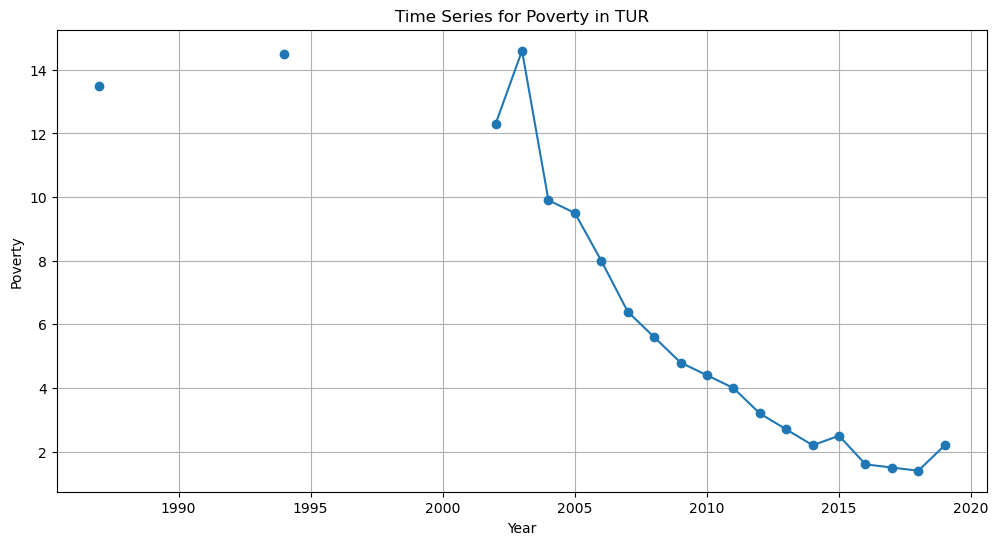

In [177]:
plot_time_series(wb_data, "TUR", "Poverty")

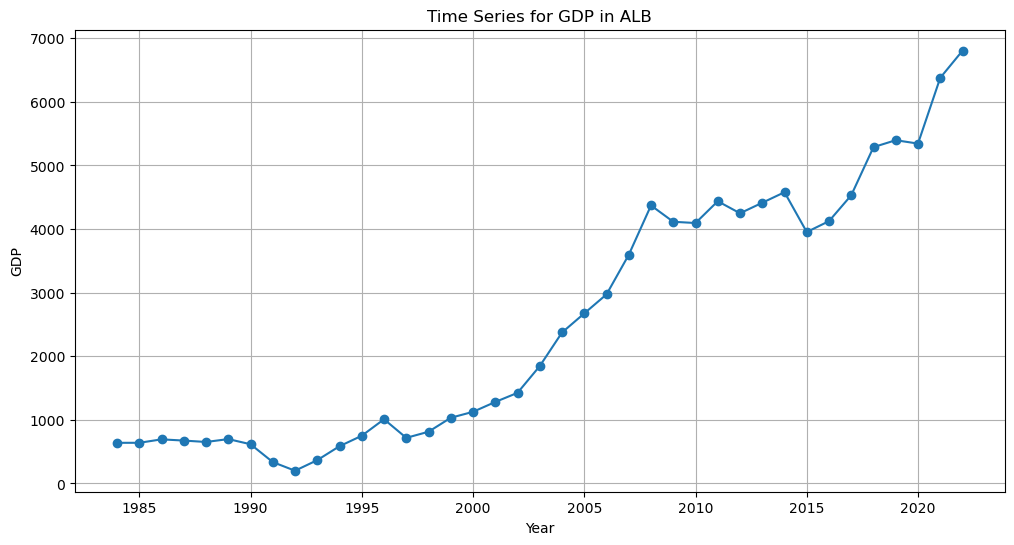

In [176]:
plot_time_series(wb_data, "ALB", "GDP")

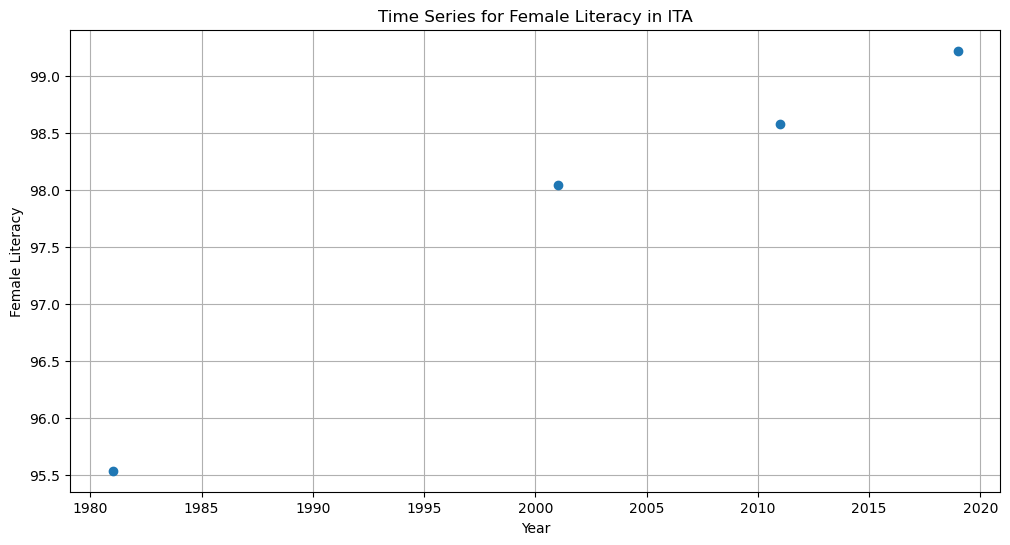

In [179]:
plot_time_series(wb_data, "ITA", "Female Literacy")

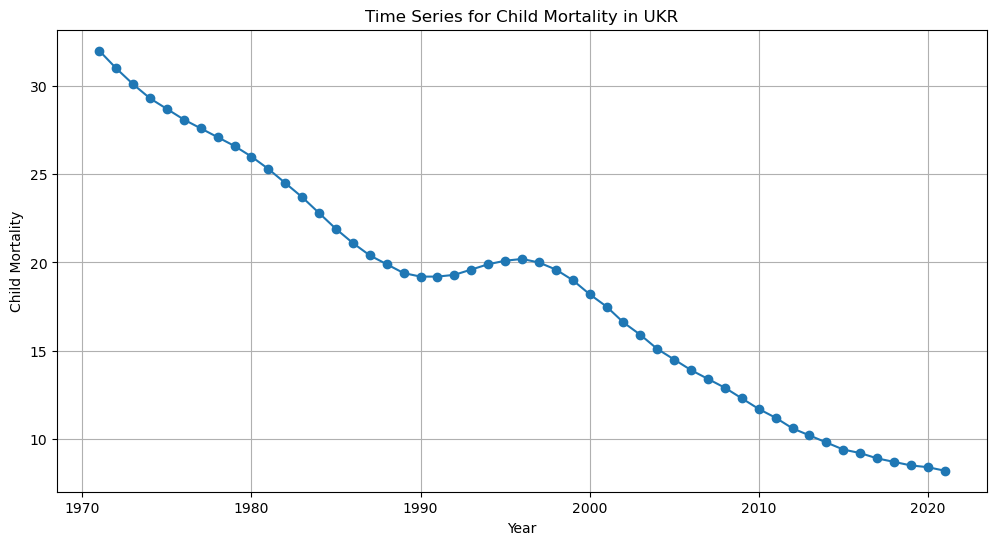

In [182]:
plot_time_series(wb_data, "UKR", "Child Mortality")

I create a function that plots the relationship between two different parameters for a country and show 4 examples

In [340]:
def plot_scatter(data, country, column1, column2, year):

    country_data = data.xs(country)[year[0] - 1960: year[-1] - 1959]

    plt.figure(figsize=(12, 6))
    plt.scatter(country_data[column1], country_data[column2], marker='o')

    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.grid(True)
    plt.show()

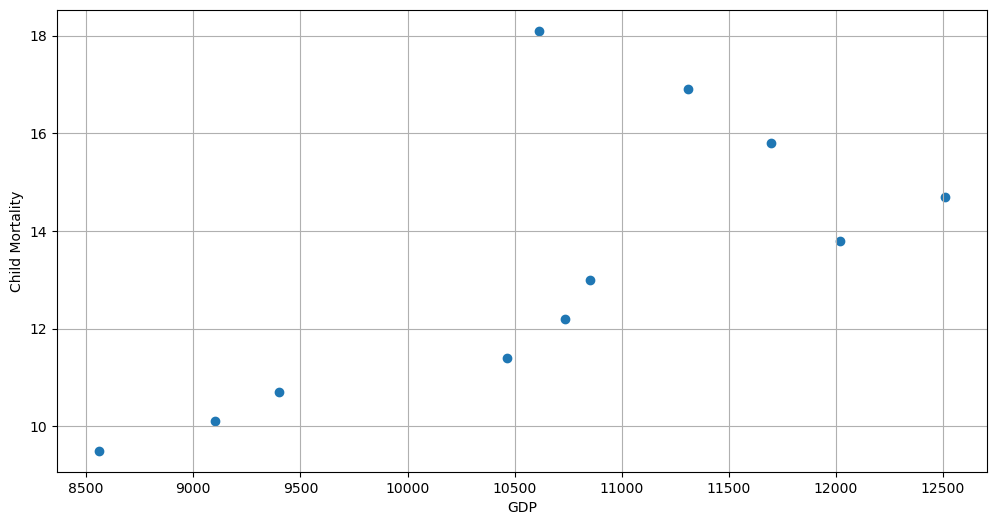

In [341]:
plot_scatter(wb_data, "TUR", "GDP", "Child Mortality", [2010,2020])

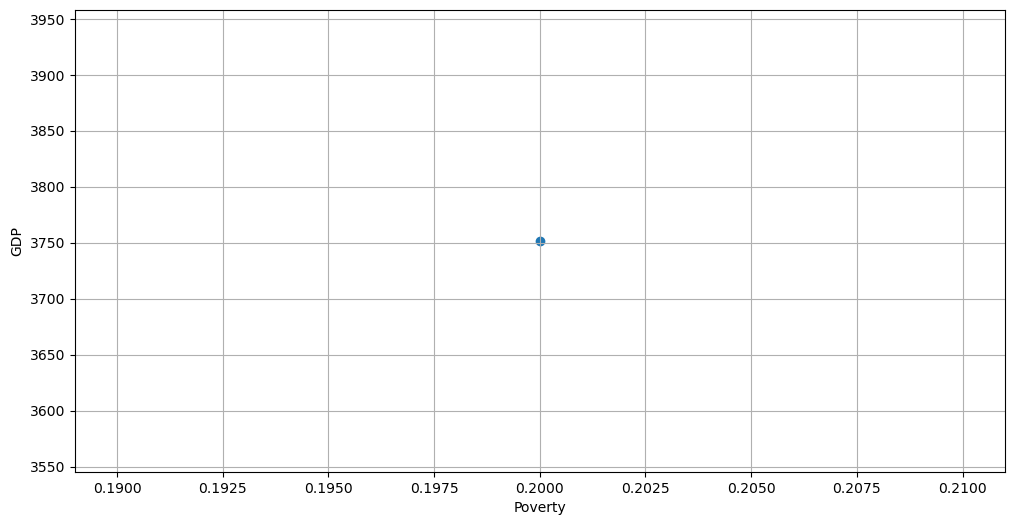

In [347]:
plot_scatter(wb_data, "UKR", "Poverty", "GDP", [2010,2020])

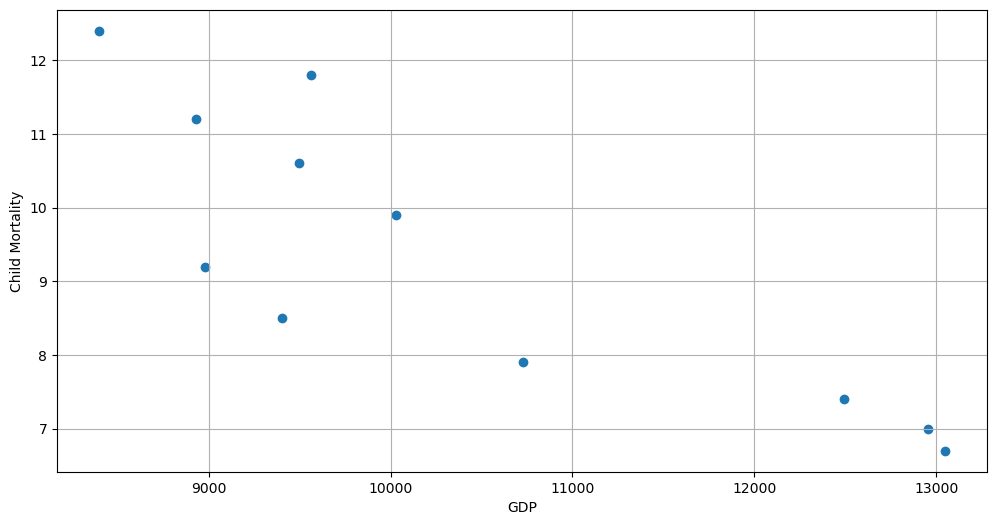

In [355]:
plot_scatter(wb_data, "ROU", "GDP", "Child Mortality", [2010,2020])

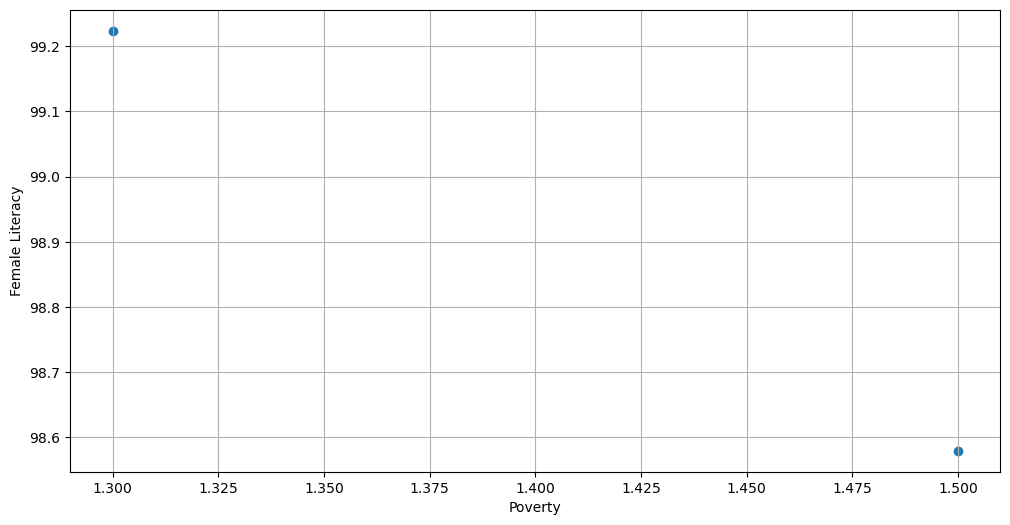

In [362]:
plot_scatter(wb_data, "ITA", "Poverty", "Female Literacy", [2010,2020])

I plot the relationship between Female Literacy and Child Mortality for all countries. The graph shows that very low Female Literacy is associated with a large increase in Child mortality. This child mortality rate decreases steadily with increasing Female literacy.

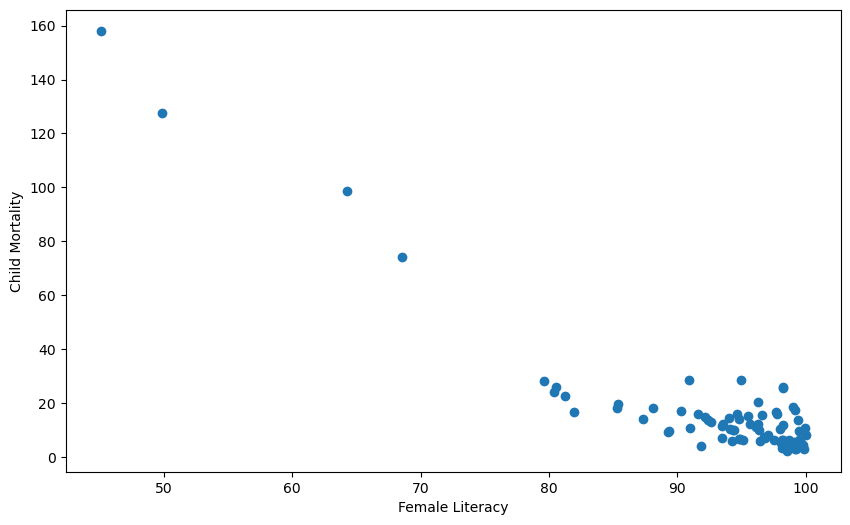

In [318]:
plt.figure(figsize=(10, 6))
plt.scatter(wb_data['Female Literacy'], wb_data['Child Mortality'])
plt.xlabel('Female Literacy')
plt.ylabel('Child Mortality')
plt.show()

Here, we are examining the relationship between Female Workforce Participation and child mortality. Since we do not have data with high Female Workforce Participation rates, we cannot comment on this issue, but there does not seem to be a serious correlation between these two parameters at low levels.

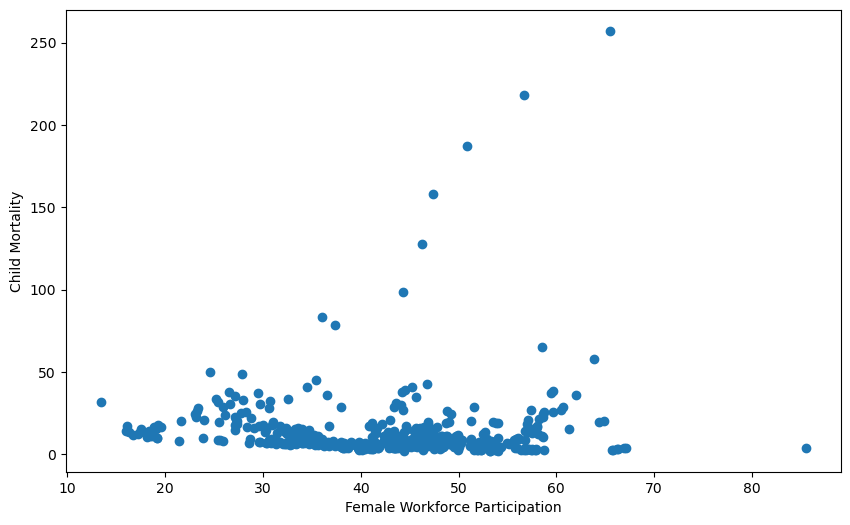

In [322]:
plt.figure(figsize=(10, 6))
plt.scatter(wb_data['Female Workforce Participation'], wb_data['Child Mortality'])


plt.xlabel('Female Workforce Participation')
plt.ylabel('Child Mortality')
plt.show()

here we examine the relationship between Gender equality and Female literacy with violin plot

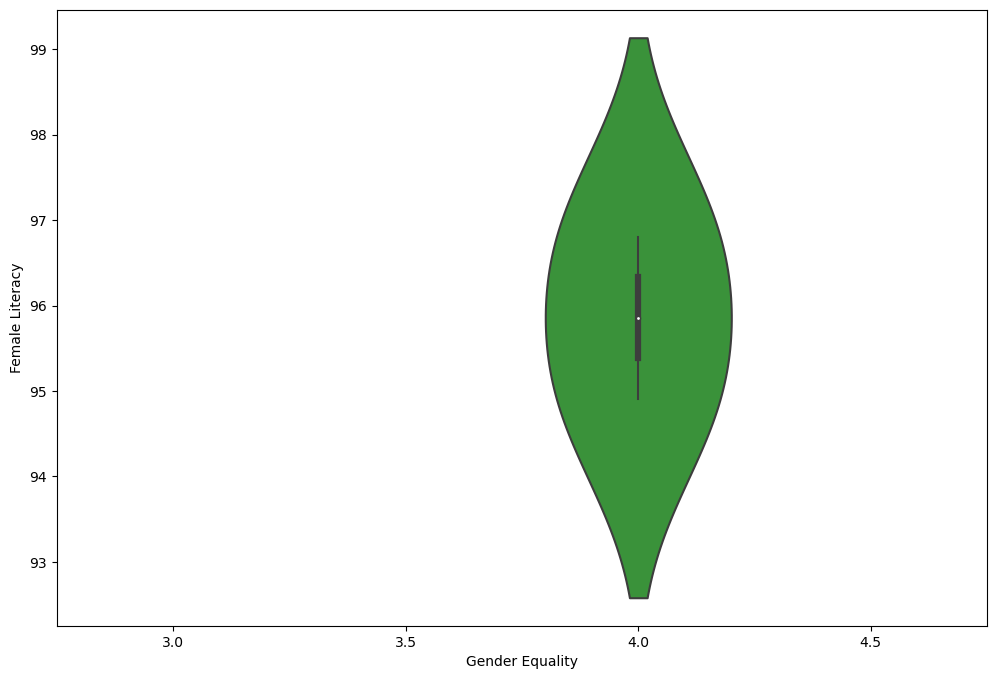

In [328]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Gender Equality', y='Female Literacy', data=wb_data, split=True)
plt.xlabel('Gender Equality')
plt.ylabel('Female Literacy')
plt.show()

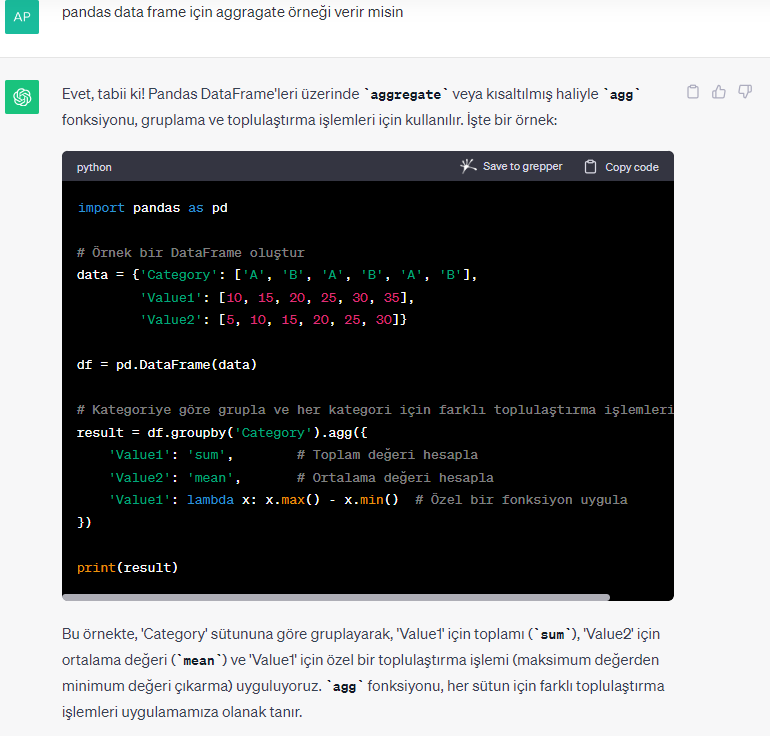

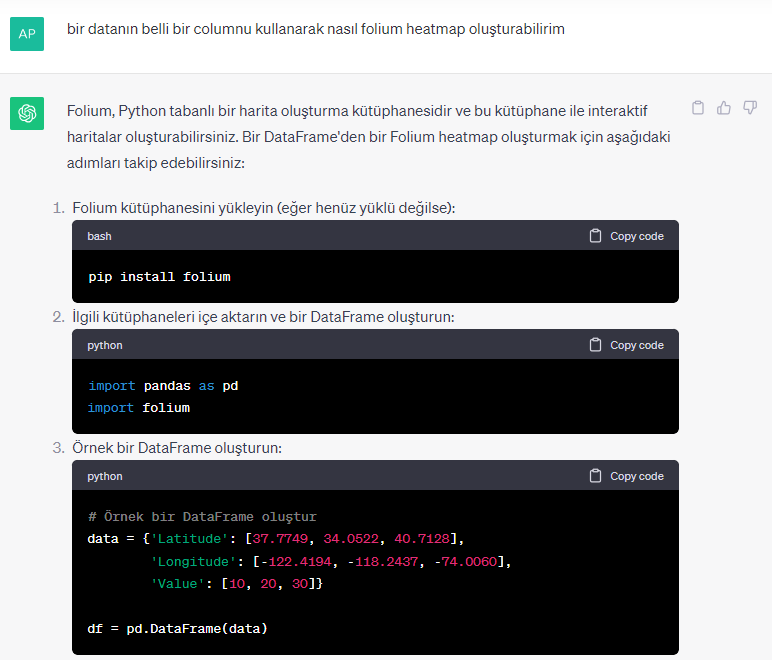